# Data preperation

In [1]:
import os
import sys
import pydicom
import numpy as np
from glob import glob
from skimage.io import imread
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from utils import *

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


/home/vafaeisa/anaconda3/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:43: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20210326). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [2]:
if not in_notebook():
    import argparse
    parser = argparse.ArgumentParser(description='MODEL ACTIVITY ANALYZER.')
    parser.add_argument('--dataset', default='./dataset', type=str, help='path to dataset')
    parser.add_argument('--model', default='model file name', type=str, help='model file name')
    parser.add_argument('--lx', default=0, type=int, help='image length')
    parser.add_argument('--ly', default=0, type=int, help='image width')
    parser.add_argument('--n_sample', default=4, type=int, help='number of sample')
    parser.add_argument('--epochs', default=200, type=int, help='number of epochs')
    parser.add_argument('--BS', default=32, type=int, help='number of epochs')
    parser.add_argument('--prefix', default='', type=str, help='path to save the results')
#     parser.add_argument('--deep', default=0, type=int, help='Network depth!')
#     parser.add_argument('--dpi', default=200, type=int, help='image dpi')
    parser.add_argument('--restart', action="store_true")

    args = parser.parse_args()
    data_path = args.dataset
    lx,ly = args.lx,args.ly
    n_sample = args.n_sample
    restart = args.restart
    EPOCHS = args.epochs
    BS = args.BS
    pp = args.pp
    reg = args.reg
#     dpi = args.dpi
    prefix = args.prefix+'/'
#     DEEP = args.deep
else:
    data_path = 'Alzheimer_dataset/train'
    lx,ly = 128,128
    n_sample = 4
    restart = 0
    EPOCHS = 1
    BS = 32
#     dpi = args.dpi
    prefix = 'alz1/'

In [3]:
paths = glob(data_path+'/*')
fname = '{}-{}-{}'.format(data_path.split('/')[-1],lx,ly)
if not os.path.isfile(fname+'.npz'):# or restart:
    print("[INFO] reading data and preparation...")
    x = []
    labels = []
    full_path = []
    for path in paths:
        files = glob(path+'/*')
        for fil in files:
            try:
                img = imread(fil)
                if lx*ly!=0:
                    img = resize(img,output_shape=(lx,ly))
                if img.ndim==3:
                    img = np.mean(img,axis=-1)
                x.append(img)
                labels.append(fil.split('/')[-2])
                full_path.append(fil)
            except:
                print('Something is wrong with',fil,', skipped.')
    print("[INFO] prepared data is saved.")
    np.savez(fname,x=x,labels=labels,full_path=full_path)
    x = np.array(x)
    labels = np.array(labels)
else:
    data = np.load(fname+'.npz'.format(lx,ly))
    x = data['x']
    labels = data['labels']
    full_path = data['full_path']
    print("[INFO] data is loaded...")

[INFO] data is loaded...


In [4]:
int_map,lbl_map = int_label(labels)
vec = [int_map[word] for word in labels]
vec = np.array(vec)

In [8]:
y = to_categorical(vec, num_classes=None, dtype='float32')
x = x[:,:,:,None]/x.max()
x = 2*x-1

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.03,
    height_shift_range=0.03,
#   brightness_range=0.01,
#   shear_range=0.0,
    zoom_range=0.03,
#   horizontal_flip=True,
#   vertical_flip=True,
    fill_mode="nearest")
describe_labels(y,verbose=1)
x_us,y_us = balance_aug(x,y,trainAug)
# x_us,y_us = mixup(x,y,alpha=20,beta=1)
describe_labels(y_us,verbose=1)
x_us,y_us = shuffle_data(x_us,y_us)

train_x0 = x_us[y_us[:,0].astype(bool)]
train_x1 = x_us[y_us[:,1].astype(bool)]
test_x0 = train_x0[:20]
test_x1 = train_x1[:20]

print(train_x0.shape,train_x1.shape)

labels/numbers are:
 0    /  2509
 1    /  2560

labels/numbers are:
 0    /  2560
 1    /  2560

(2560, 128, 128, 1) (2560, 128, 128, 1)


In [9]:
x.shape,vec.shape

((5069, 128, 128, 1), (5069,))

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from utils import *

In [10]:
#input_img_size = (256, 256, 1)
input_img_size = x.shape[1:]

buffer_size = 256
batch_size = 10

# Get the generators
gen_G = get_resnet_generator(input_img_size,name="generator_G")
gen_F = get_resnet_generator(input_img_size,name="generator_F")

# Get the discriminators
disc_X = get_discriminator(input_img_size,name="discriminator_X")
disc_Y = get_discriminator(input_img_size,name="discriminator_Y")

# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=5e-5, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=5e-5, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=5e-5, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=5e-5, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

In [ ]:
continue_training = False
if continue_training:
    cycle_gan_model.loadit('model1/')

cycle_gan_model.fit(
    train_x0, train_x1,
    batch_size=2,
    epochs=2,
)

cycle_gan_model.saveit('model1/')

In [11]:
cycle_gan_model.loadit('model1/')

In [12]:
from matplotlib.colors import LogNorm

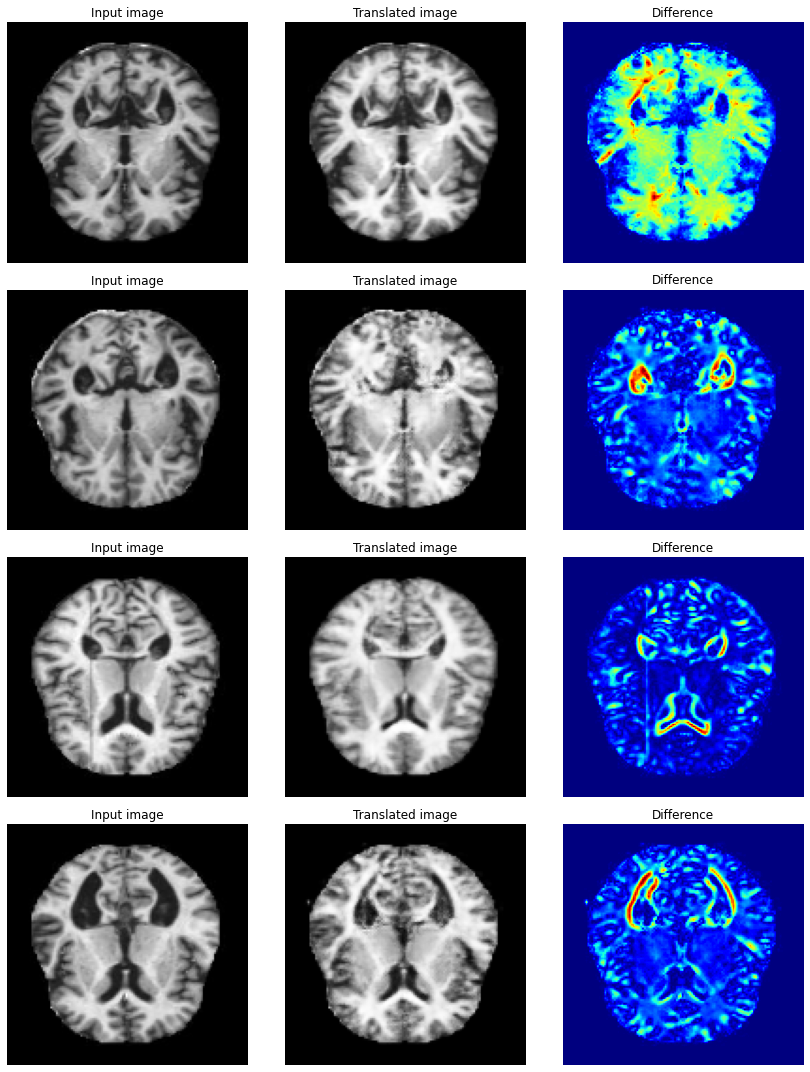

In [14]:
_, ax = plt.subplots(4, 3, figsize=(12, 15))
#for i, img in enumerate(test_horses.take(4)):
for i in range(4):
    img = test_x0[i:i+1]
    prediction = np.array(cycle_gan_model.gen_G(img, training=False)[0])

    ax[i, 0].imshow(img[0],cmap='gray')
    ax[i, 1].imshow(prediction,cmap='gray')
    ax[i, 2].imshow(np.abs(img[0]-prediction),cmap='jet')
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 2].set_title("Difference")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")

#     prediction = keras.preprocessing.image.array_to_img(prediction)
#     prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
# plt.show()

# plt.savefig('fig.jpg',dpi=150)


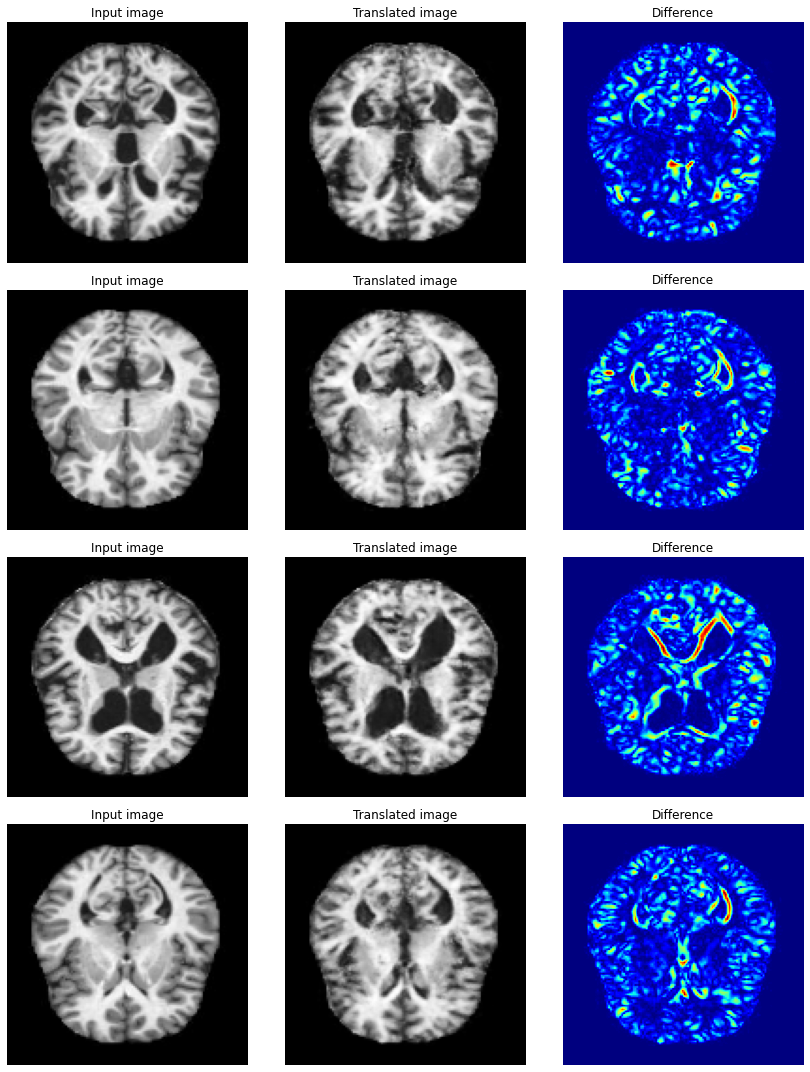

In [15]:
_, ax = plt.subplots(4, 3, figsize=(12, 15))
#for i, img in enumerate(test_horses.take(4)):
for i in range(4):
    img = test_x1[i:i+1]
    prediction = np.array(cycle_gan_model.gen_F(img, training=False)[0])

    ax[i, 0].imshow(img[0],cmap='gray')
    ax[i, 1].imshow(prediction,cmap='gray')
    ax[i, 2].imshow(np.abs(img[0]-prediction),cmap='jet')
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 2].set_title("Difference")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")

#     prediction = keras.preprocessing.image.array_to_img(prediction)
#     prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
# plt.show()

# plt.savefig('fig.jpg',dpi=150)


In [16]:
#for i, img in enumerate(test_horses.take(4)):
delta = []
for i in range(len(train_x0)):
    img = train_x0[i:i+1]
    prediction = np.array(cycle_gan_model.gen_G(img, training=False)[0])
    delta.append(np.abs(img-prediction))
delta = np.concatenate(delta)
delta.shape

(2560, 128, 128, 1)

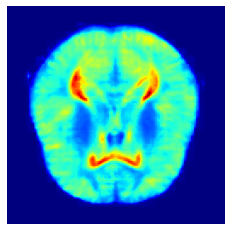

In [17]:
plt.imshow(np.mean(delta,(0,3)),cmap='jet')
plt.axis('off')
plt.savefig('dementia-ganG.jpg')

In [18]:
#for i, img in enumerate(test_horses.take(4)):
delta = []
for i in range(len(train_x0)):
    img = train_x1[i:i+1]
    prediction = np.array(cycle_gan_model.gen_F(img, training=False)[0])
    delta.append(np.abs(img-prediction))
delta = np.concatenate(delta)
delta.shape

(2560, 128, 128, 1)

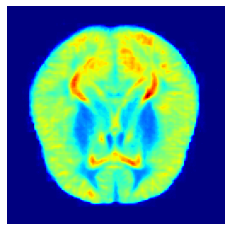

In [19]:
plt.imshow(np.mean(delta,(0,3)),cmap='jet')
plt.axis('off')
plt.savefig('dementia-ganF.jpg')

# THE END.

In [27]:
y = to_categorical(vec, num_classes=None, dtype='float32')
x = x[:,:,:,None]/x.max()
x = 2*x-1

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.03,
    height_shift_range=0.03,
#   brightness_range=0.01,
#   shear_range=0.0,
    zoom_range=0.03,
#   horizontal_flip=True,
#   vertical_flip=True,
    fill_mode="nearest")
describe_labels(y,verbose=1)
x_us,y_us = balance_aug(x,y,trainAug)
# x_us,y_us = mixup(x,y,alpha=20,beta=1)
describe_labels(y_us,verbose=1)
x_us,y_us = shuffle_data(x_us,y_us)

train_x0 = x_us[y_us[:,0].astype(bool)]
train_x1 = x_us[y_us[:,1].astype(bool)]
test_x0 = train_x0[:20]
test_x1 = train_x1[:20]

print(train_x0.shape,train_x1.shape)

In [29]:
#input_img_size = (256, 256, 1)
input_img_size = x.shape[1:]

buffer_size = 256
batch_size = 10

# Get the generators
gen_G = get_resnet_generator(input_img_size,name="generator_G")
gen_F = get_resnet_generator(input_img_size,name="generator_F")

# Get the discriminators
disc_X = get_discriminator(input_img_size,name="discriminator_X")
disc_Y = get_discriminator(input_img_size,name="discriminator_Y")

# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=5e-5, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=5e-5, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=5e-5, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=5e-5, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

In [30]:
# fake_train_x1 = self.gen_G(real_train_x0)
# fake_train_x0 = self.gen_F(real_train_x1)

In [31]:
cycle_gan_model.fit(
    train_x0[:1000], train_x1[:1000],
    batch_size=10,
    epochs=1,
#    callbacks=[plotter, model_checkpoint_callback],
)

100/100 [==============================] - 586s 6s/step - G_loss: 9.9249 - F_loss: 9.8458 - D_X_loss: 0.3117 - D_Y_loss: 0.3002


In [57]:
cycle_gan_model.saveit('model1/')

In [58]:
cycle_gan_model.loadit('model1/')

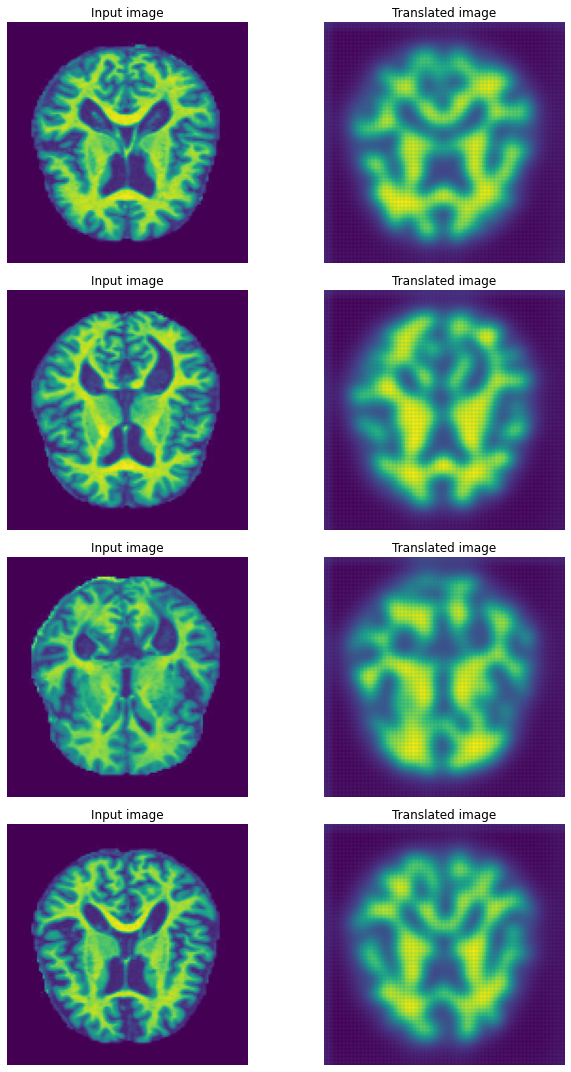

<Figure size 432x288 with 0 Axes>

In [59]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
#for i, img in enumerate(test_horses.take(4)):
for i in range(4):
    img = test_x0[i:i+1]
    prediction = np.array(cycle_gan_model.gen_G(img, training=False)[0])
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).astype(np.uint8) #.numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = keras.preprocessing.image.array_to_img(prediction)
    prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show()

plt.savefig('fig.jpg',dpi=150)


In [60]:
inds = np.argsort(np.mean(x,axis=(1,2,3)))

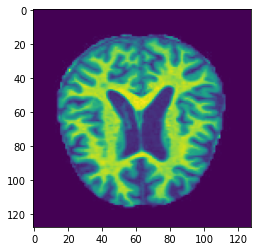

In [61]:
iii = inds[90]
plt.imshow(x[iii,:,:,0])

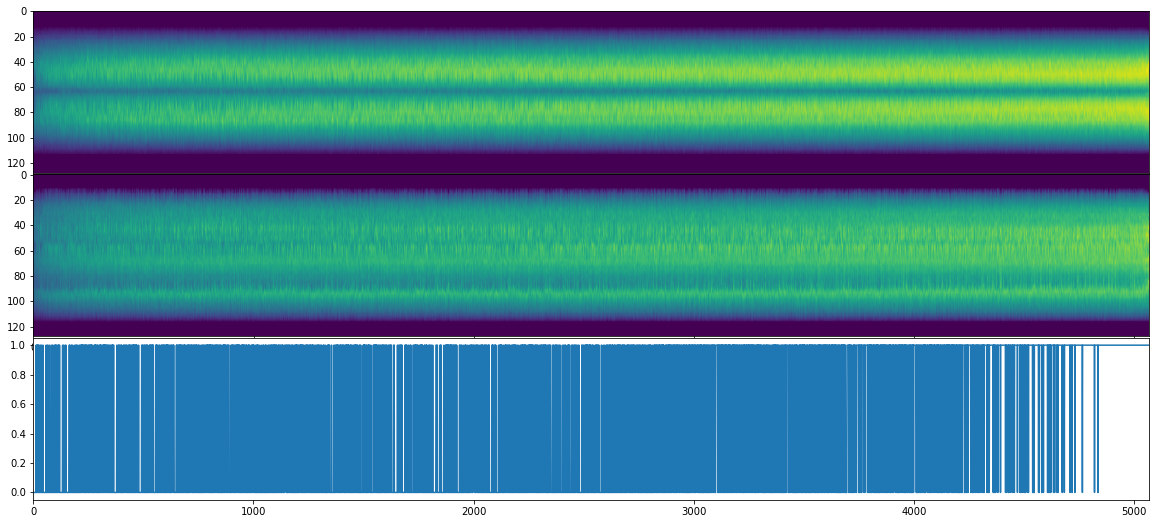

In [62]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,9))
ax1.imshow(np.mean(x[inds,:,:,0],axis=1).T,aspect='auto')
ax1.set_xticks([])
ax2.imshow(np.mean(x[inds,:,:,0],axis=2).T,aspect='auto')
ax1.set_xticks([])
ax3.plot(vec[inds])
ax3.set_xlim(0,x.shape[0])
plt.subplots_adjust(hspace=0.01)

In [87]:
x_us.dtype

dtype('float64')

In [88]:
x_us = x_us.astype(np.float32)
y_us = y_us.astype(np.float32)

In [90]:
# Put aside a few samples to create our validation set
BATCH_SIZE = BS

train_ds_one = (
    tf.data.Dataset.from_tensor_slices((x_us, y_us))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((x_us, y_us))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

In [106]:
train_ds_one

<BatchDataset shapes: ((None, 128, 128, 1), (None, 2)), types: (tf.float32, tf.float32)>

In [237]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, 0.2, 0.2)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)


def random_cut(ds,ll=64):
    # Unpack two datasets
    images, labels = ds
    batch_size,lx,ly,_ = tf.shape(images_one)

    # Sample lambda and reshape it to do the mixup
    xn = np.random.randint(0,lx-ll,batch_size)
    yn = np.random.randint(0,ly-ll,batch_size)
    
    imgs = []
    for i in range(batch_size):
        imgs.append(images[i,xn+ll,yn+ll,:])

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = np.array(imgs)
    return (images, labels)

In [242]:
train_ds

<ZipDataset shapes: ((<unknown>, <unknown>), (<unknown>, <unknown>)), types: ((tf.float32, tf.float32), (tf.float32, tf.float32))>

In [239]:
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_ds.map(lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2),)

[1.0, 0.0]
[0.9951398968696594, 0.004860103130340576]
[0.262057900428772, 0.737942099571228]
[0.0, 1.0]
[9.202957153320312e-05, 0.9999079704284668]
[0.0, 1.0]
[1.0, 0.0]
[0.0, 1.0]
[0.9857321977615356, 0.014267802238464355]


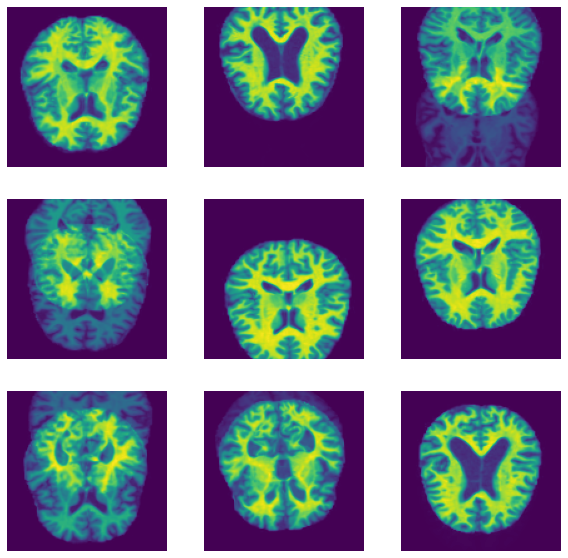

In [240]:


# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")


In [241]:
trainAug = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.03,
    height_shift_range=0.3,
#   brightness_range=0.01,
#   shear_range=0.0,
    zoom_range=0.03,
#   horizontal_flip=True,
#   vertical_flip=True,
    fill_mode="nearest")

def make_gen(x):
    def gen():
      i = 0
      while(i<len(x)):
        yield next(x)
        i +=1
    return gen

dflow1 = trainAug.flow(x_us, y_us, batch_size=BS)
dflow2 = trainAug.flow(x_us, y_us, batch_size=BS)

dflow1 = make_gen(dflow1)
dflow2 = make_gen(dflow2)

ds1 = tf.data.Dataset.from_generator(dflow1,output_types=(tf.float32,tf.float32))
ds2 = tf.data.Dataset.from_generator(dflow2,output_types=(tf.float32,tf.float32))

# ds2 = tf.data.Dataset.from_generator(dflow2,output_types=(tf.float32,tf.float32),
#                                      output_shapes=[(None,lx,ly,1),(None,2)])

train_ds = tf.data.Dataset.zip((ds1,ds2))
train_ds_mu = train_ds.map(lambda ds1, ds2: mix_up(ds1, ds2, alpha=0.2))   
# train_ds_mu = train_ds.map(lambda ds: ds)#random_cut(ds, alpha=64))                               

In [224]:
# dflow1 = trainAug.flow(x_us, y_us, batch_size=BS)
# dflow2 = trainAug.flow(x_us, y_us, batch_size=BS)

# dflow1 = make_gen(dflow1)
# dflow2 = make_gen(dflow2)

# ds1 = tf.data.Dataset.from_generator(dflow1,output_types=(tf.float32,tf.float32))
# ds2 = tf.data.Dataset.from_generator(dflow2,output_types=(tf.float32,tf.float32))

# # ds1 = tf.data.Dataset.from_generator(dflow1,output_types=(tf.float32,tf.float32),
# #                                      output_shapes=(tf.TensorShape((None, 128, 128, 1)), tf.TensorShape(None)))
# # ds2 = tf.data.Dataset.from_generator(dflow2,output_types=(tf.float32,tf.float32),
# #                                      output_shapes=(tf.TensorShape((None, 128, 128, 1)), tf.TensorShape(None)))

# train_ds = tf.data.Dataset.zip((ds1,ds2))
# # train_ds_mu = train_ds.map(lambda ds1, ds2: mix_up(ds1, ds2, alpha=0.2))
# train_ds_mu = train_ds.map(lambda ds1, ds2: ds1)


[0.9292031526565552, 0.07079685479402542]
[0.8474373817443848, 0.15256258845329285]
[0.5966663956642151, 0.4033336043357849]
[0.0, 1.0]
[0.7888724207878113, 0.21112759411334991]
[0.9943898320198059, 0.005610167980194092]
[0.04719635471701622, 0.9528036713600159]
[0.02434253692626953, 0.9756574630737305]
[0.0, 1.0]


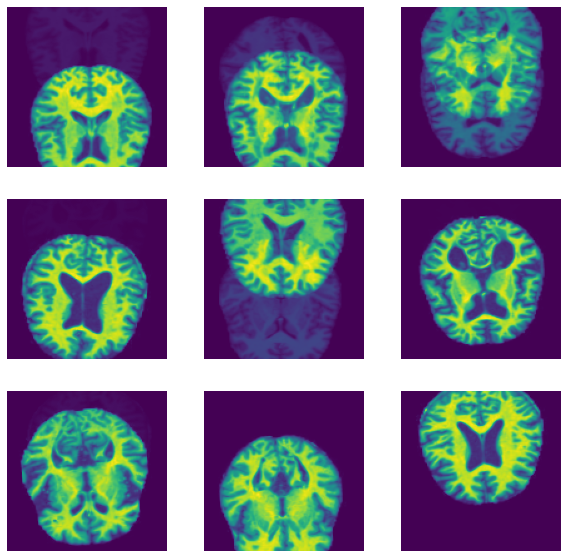

In [243]:
# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")


In [212]:
x20 = []
for sample_images, sample_labels in train_ds_mu:
    print(sample_images.shape,sample_labels.shape)
    break
    x20.append(sample_images)

(32, 128, 128, 1) (32, 2)


In [181]:
x_us.shape

(5120, 128, 128, 1)

In [219]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

l1 = 0.01
n_class = 2

input_img = keras.Input(shape=(128, 128, 1))
labels = keras.Input(shape=(2,))
wieghts = keras.Input(shape=())

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', activity_regularizer=regularizers.l1(l1))(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', activity_regularizer=regularizers.l1(l1))(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', activity_regularizer=regularizers.l1(l1))(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', activity_regularizer=regularizers.l1(l1))(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
#     print(sh)
x = layers.Flatten()(x)

output = layers.Dense(n_class, activation='sigmoid',
            activity_regularizer=regularizers.l1(l1))(x)

model = keras.Model(input_img, output, name='encoder')
model.compile(optimizer="Adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=["acc"])

In [220]:
# dflow1 = trainAug.flow(x_us, y_us, batch_size=BS)


model.fit(train_ds_mu.as_numpy_iterator(),batch_size=32)

160/160 [==============================] - 14s 81ms/step - loss: 123.0968 - acc: 0.5138


In [201]:
model.fit(train_ds_mu,batch_size=512)

AttributeError: 'MapDataset' object has no attribute 'batch_size'

In [190]:
dflow1

In [198]:
train_ds_mu.as_numpy_iterator()